# Week 10.3.1 Topic Modelling using LDA

## Preparation

In this exercise, we will need to make sure the following packages are installed into your conda environment that runs this Jupyter notebook. 

`pip install gensim spacy pyLDAvis matplotlib numpy pandas`

To view the list of modules or packages installed, use

`conda list`

Then install the ones you do not have. Once installed, we can then import them and be prepared for the rest of the exercise. 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

c:\users\wei\appdata\local\conda\conda\envs\py3.7\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\wei\appdata\local\conda\conda\envs\py3.7\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
c:\users\wei\appdata\local\conda\conda\envs\py3.7\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


### Define stop words

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
pprint(stop_words)

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Import 20-Newsgroups dataset

The 20-Newsgroups dataset contains about 11k newsgroups posts from 20 different topics. 

The dataset can be imported using `pandas.read_json` and we can see the dataset has 3 columns. The `target-name` is the category or topics that the news is manually assigned to. 

We choose to use this dataset because it has pre-assigned categories according to topics, so our clustering results can be readily compared. In real world data, this is not always easily available. 

In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


## Pre-processing
### Removing emails and newline characters

We can use regular expressions for this purpose by untilising the `re` package.

In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


### Tokenisation

We need to break down each sentence into a list of words, for the data to be ready for consumption by `gensim`. The `simple_preprocess()` function is built for such purposes. We can also set the `deacc=True` to remove punctuations. 

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


### Creating bigram and trigrams - Gensim’s Phrases model

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

c:\users\wei\appdata\local\conda\conda\envs\py3.7\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


### Build functions for the pre-processing pipeline

Remove stopwords, make bigram and trigrams, and lemmatisation.

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Call the functions in order

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

c:\users\wei\appdata\local\conda\conda\envs\py3.7\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
c:\users\wei\appdata\local\conda\conda\envs\py3.7\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatev', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


In [10]:
print(corpus[0])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]


In [11]:
print(id2word[0])

addition


In [12]:
print(corpus[0][0])

(0, 1)


In [13]:
sorted_by_value = sorted(corpus[0], key=lambda kv: kv[1], reverse=True)
print(sorted_by_value)

[(6, 5), (1, 2), (9, 2), (22, 2), (0, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (8, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]


In [14]:
# Human readable format of corpus (term-frequency)
[(id2word[id], freq) for id, freq in sorted_by_value] 

[('car', 5),
 ('anyone', 2),
 ('door', 2),
 ('look', 2),
 ('addition', 1),
 ('body', 1),
 ('bricklin', 1),
 ('bring', 1),
 ('call', 1),
 ('could', 1),
 ('day', 1),
 ('early', 1),
 ('engine', 1),
 ('enlighten', 1),
 ('front_bumper', 1),
 ('funky', 1),
 ('history', 1),
 ('host', 1),
 ('info', 1),
 ('know', 1),
 ('late', 1),
 ('lerxst', 1),
 ('line', 1),
 ('mail', 1),
 ('make', 1),
 ('maryland_college', 1),
 ('model', 1),
 ('name', 1),
 ('neighborhood', 1),
 ('nntp_post', 1),
 ('organization', 1),
 ('park', 1),
 ('production', 1),
 ('rac_wam', 1),
 ('really', 1),
 ('rest', 1),
 ('s', 1),
 ('see', 1),
 ('separate', 1),
 ('small', 1),
 ('spec', 1),
 ('sport', 1),
 ('tellme', 1),
 ('thank', 1),
 ('thing', 1),
 ('umd', 1),
 ('university', 1),
 ('whatev', 1),
 ('where', 1),
 ('wonder', 1),
 ('year', 1)]

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"_" + 0.029*"blue" + 0.021*"tank" + 0.014*"cubs_suck" + 0.012*"eg" + '
  '0.012*"gas" + 0.011*"hi" + 0.007*"henry_spencer" + 0.007*"cigarette" + '
  '0.006*"xlib"'),
 (1,
  '0.020*"value" + 0.020*"bus" + 0.019*"specifically" + 0.015*"function" + '
  '0.015*"associate" + 0.013*"motorcycle" + 0.011*"properly" + 0.010*"code" + '
  '0.008*"confuse" + 0.008*"error"'),
 (2,
  '0.023*"window" + 0.020*"card" + 0.017*"file" + 0.014*"drive" + 0.013*"use" '
  '+ 0.013*"system" + 0.011*"problem" + 0.010*"run" + 0.009*"color" + '
  '0.009*"do"'),
 (3,
  '0.035*"game" + 0.033*"team" + 0.019*"player" + 0.017*"play" + 0.017*"win" + '
  '0.016*"hockey" + 0.013*"season" + 0.011*"contact" + 0.011*"year" + '
  '0.010*"nhl"'),
 (4,
  '0.026*"wire" + 0.017*"circuit" + 0.015*"faq" + 0.015*"connect" + '
  '0.013*"wiring" + 0.013*"voice" + 0.013*"cover" + 0.011*"outlet" + '
  '0.011*"neutral" + 0.010*"conference"'),
 (5,
  '0.030*"government" + 0.024*"gun" + 0.022*"law" + 0.017*"state" + '
  '0.0

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.754098376125084

Coherence Score:  0.515758393754623


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

c:\users\wei\appdata\local\conda\conda\envs\py3.7\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.336841 -0.001183       1        1  16.240536
13     0.291028 -0.003249       2        1  15.222937
18     0.328831 -0.128123       3        1  14.586681
2      0.091778  0.226472       4        1   6.162445
15     0.059631  0.222477       5        1   5.973765
10    -0.085006 -0.113080       6        1   4.344127
17     0.060749 -0.183168       7        1   4.177628
12    -0.021541 -0.036677       8        1   3.603021
5     -0.022900 -0.021314       9        1   3.365298
16    -0.029244  0.219705      10        1   3.271771
6     -0.062992 -0.016657      11        1   3.222933
9     -0.062884  0.139431      12        1   2.968332
14    -0.088884 -0.062644      13        1   2.740086
3     -0.047752 -0.117436      14        1   2.731137
8     -0.111456  0.003704      15        1   2.291876
19    -0.113684 -0.023385      16        1   2.124456
11    -0.092440 -0.110498      17        1   2.077360
4     -0.134206  0.001651      18        1   1.694626
0     -0.164227 -0.027994      19        1   1.679200
1     -0.131640  0.031969      20        1   1.521798, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
4146   Default  57084.000000            ax  57084.000000  30.0000  30.0000
21     Default  12491.000000          line  12491.000000  29.0000  29.0000
82     Default  16290.000000           not  16290.000000  28.0000  28.0000
30     Default  11142.000000  organization  11142.000000  27.0000  27.0000
3721   Default   3844.000000           max   3844.000000  26.0000  26.0000
65     Default  10452.000000            do  10452.000000  25.0000  25.0000
322    Default   9655.000000         write   9655.000000  24.0000  24.0000
55     Default   7586.000000       article   7586.000000  23.0000  23.0000
244    Default   8046.000000            be   8046.000000  22.0000  22.0000
154    Default  11782.000000         would  11782.000000  21.0000  21.0000
303    Default   6905.000000           say   6905.000000  20.0000  20.0000
226    Default   5803.000000            go   5803.000000  19.0000  19.0000
29     Default   4407.000000     nntp_post   4407.000000  18.0000  18.0000
16     Default   4083.000000          host   4083.000000  17.0000  17.0000
118    Default   6852.000000           get   6852.000000  16.0000  16.0000
46     Default   5027.000000    university   5027.000000  15.0000  15.0000
1911   Default   1863.000000         space   1863.000000  14.0000  14.0000
215    Default   2294.000000        window   2294.000000  13.0000  13.0000
36     Default   3735.000000             s   3735.000000  12.0000  12.0000
18     Default   7291.000000          know   7291.000000  11.0000  11.0000
50     Default   3461.000000          year   3461.000000  10.0000  10.0000
317    Default   4598.000000           use   4598.000000   9.0000   9.0000
2726   Default   1540.000000          game   1540.000000   8.0000   8.0000
23     Default   1949.000000          mail   1949.000000   7.0000   7.0000
681    Default   3005.000000         right   3005.000000   6.0000   6.0000
967    Default   1685.000000     christian   1685.000000   5.0000   5.0000
1362   Default   1746.000000    government   1746.000000   4.0000   4.0000
567    Default   1464.000000          team   1464.000000   3.0000   3.0000
206    Default   3380.000000        system   3380.000000   2.0000   2.0000
60     Default   2012.000000          card   2012.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
11736  Topic20    119.370399          guru    120.322311   4.1773  -5.3260
3548   Topic20    117.622925  countersteer    118.574837   4.1772  -5.3407
10436  Topic20    113.025604       bradley    113.977516   4.1769  -5.3806
280    Topic20    112.216255          lane    113.168167   4.1768  -5

In [19]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'C:\\Users\\wei\\notebooks\\mallet-2.0.8\\bin\\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(4,
  [('game', 0.024669252959315626),
   ('team', 0.01804187804635432),
   ('year', 0.014622500746045956),
   ('play', 0.014038098080175072),
   ('player', 0.012061076295633145),
   ('win', 0.010904705063165224),
   ('good', 0.010419775191485129),
   ('season', 0.007734009748333831),
   ('hockey', 0.00693822739480752),
   ('fan', 0.006540336218044365)]),
 (14,
  [('write', 0.011085139030301292),
   ('question', 0.01009565055282291),
   ('science', 0.00980884229848135),
   ('exist', 0.00973714023489596),
   ('evidence', 0.008346120201339395),
   ('argument', 0.00815969483601738),
   ('system', 0.00810233318514907),
   ('make', 0.00810233318514907),
   ('reason', 0.007256248834841467),
   ('thing', 0.007041142644085297)]),
 (11,
  [('drug', 0.00915375864181325),
   ('research', 0.0075610396429509055),
   ('study', 0.007035967445523759),
   ('food', 0.006913450599457425),
   ('problem', 0.0061433447098976105),
   ('doctor', 0.0057932965782795135),
   ('disease', 0.00556576529272775),
  

## How to find the best number of topics

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

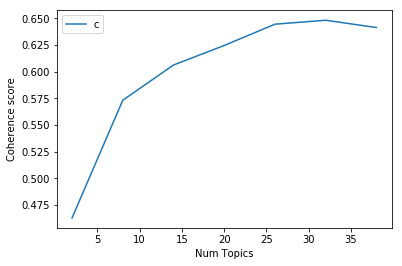

In [23]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()